# Documentation

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
# Aquaplanet analysis config file
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# File management
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Data anaylsis
import numpy as np
import scipy
import xarray as xr
xr.set_options(keep_attrs=True)
import scipy.signal as signal
from scipy.stats import t

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
from cartopy import util as cutil
from plotting_functions import *

# Auxiliary functions
from load_aquaplanet_data import *
from processing_functions import *
from auxiliary_functions.modified_colormap import modified_colormap
from auxiliary_functions.bmh_colors import bmh_colors
from auxiliary_functions.one_two_one_filter import one_two_one_filter
from auxiliary_functions.tick_labeller import tick_labeller

print("Imports loaded")

Loading imports...
Imports loaded


# Specify analysis parameters

In [2]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]

START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load data

In [3]:
reload_variables = True

# experiment_to_load = '4K'
variables_to_load = [
    "Precipitation",
    # "Outgoing Longwave Radiation",
    "Zonal Wind",
    "Meridional Wind",
    "Vertical Wind",
    "Temperature",
    # "Moisture",
    # "Relative Humidity",
    # "Geopotential Height",
    # "Longwave Heating Rate",
    # "Shortwave Heating Rate",
    # "Latent Heat Flux",
    # "Sensible Heat Flux",
    # "Surface Pressure",
    # "Moist Static Energy",
    # "Column Moist Static Energy",
    # "Column Water Vapor",
    # "Column Temperature",
    # "Column Longwave Heating",
    # "Column Shortwave Heating",
    # "Potential Temperature",
    # "Saturation Specific Humidity"
    # "Column Relative Humidity",
    # "Diabatic Heating",
    # "Chikira alpha"
    # "Surface Longwave Flux",
    # "Surface Shortwave Flux",
    # "TOA Longwave Flux",
    # "TOA Shortwave Flux",
    # "Net Longwave Flux",
    # "Net Shortwave Flux",
]

# if reload_variables or 'variables_dict' not in globals():
#     variables_dict = load_aquaplanet_data(variables_to_load, experiment_to_load)
# else:
#     new_variables_dict = load_aquaplanet_data(variables_to_load, experiment_to_load)

#     # If not reloading, append new variables to existing dict
#     for variable_name, variable_data in new_variables_dict.items():
#         if variable_name not in variables_dict.keys():
#             print(f"Adding {variable_name} to Active Variables...", end="")
#             variables_dict[variable_name] = variable_data
#             print(rf"{'✔':>1}")

# print('=' * str_width)
# print(f"\nActive Variables:")
# print("\n".join([key for key in variables_dict.keys()]))

# Load pre-processed data

## Subset data

In [4]:
if not 'multi_experiment_variables_subset' in locals():
    multi_experiment_variables_subset = load_multi_experiment_processed_data(
        variables_to_load,
        'subset'
    )
else:
    multi_experiment_variables_subset = load_multi_experiment_processed_data(
        variables_to_load,
        'subset',
        multi_experiment_variables_subset,
        False
    )

          Loading subset data           
(1/5) Precipitation...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(2/5) Zonal Wind...                     
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(3/5) Meridional Wind...                
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(4/5) Vertical Wind...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                

# EOF analysis

## Full horizontal fields

### Calculate EOFs

In [59]:
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False
calculate_eofs = True
plot_eofs = True

compositing_variable = multi_experiment_variables_subset['Vertical Wind'].sel(plev=slice(100,950), lat=slice(-10,10))
# compositing_variable = multi_experiment_variables_subset['Diabatic Heating'].copy(deep=True)
EOF = xr.DataArray(
    data = np.empty((len(experiments_list), len(compositing_variable.plev), len(compositing_variable.plev))),
    dims=["experiment", "index", "plev"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(compositing_variable.plev)+1),
        plev=compositing_variable.plev
    )
)

PC = xr.DataArray(
    data = np.empty((
        len(experiments_list),
        len(compositing_variable.plev),
        len(compositing_variable.time),
        len(compositing_variable.lat),
        len(compositing_variable.lon)
    )),
    dims=["experiment", "index", "time", "lat", "lon"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(compositing_variable.plev)+1),
        time=compositing_variable.time,
        lat=compositing_variable.lat,
        lon=compositing_variable.lon
    )
)

eigenvalue_spectrum = xr.DataArray(
    data = np.empty((len(experiments_list), len(compositing_variable.plev))),
    dims=["experiment", "index"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(compositing_variable.plev)+1),
    )
)

spectrum_error = xr.DataArray(
    data = np.empty((len(experiments_list), len(compositing_variable.plev))),
    dims=["experiment", "index"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(compositing_variable.plev)+1),
    )
)

print(f"Variable: {compositing_variable.name}")

if calculate_eofs:
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{'='*40}")
        print(f"Experiment: {experiment}")
        print(f"{'='*40}")
        print("Reshaping variables...")
        reshaped_variable = np.reshape(
            compositing_variable.sel(experiment=experiment).values,
            (
                (
                    len(compositing_variable.time)
                    * len(compositing_variable.lat)
                    * len(compositing_variable.lon)
                ),
                len(compositing_variable.plev),
            ),
        )
        print("Variables reshaped")

        #### Calculate EOFs and PCs
        print("Computing EOFs...")
        U, S, VT = np.linalg.svd(reshaped_variable.T, full_matrices=False)
        EOF[experiment_index] = U.T*-np.sign(U.T[0, -1])
        PC[experiment_index] = np.reshape(
            np.dot(np.diag(S), VT),
            (
                len(compositing_variable.plev),
                len(compositing_variable.time),
                len(compositing_variable.lat),
                len(compositing_variable.lon)
            )
        )
        print("EOFs computed")

        # Calculate nominal degrees of freedom
        nominal_degrees_of_freedom = np.size(reshaped_variable, 1)

        # Calculate eigenvalues and spectrum
        eigenvalues = S**2 / nominal_degrees_of_freedom
        eigenvalue_spectrum[experiment_index] = eigenvalues / np.sum(eigenvalues)
        explained_variance = 100 * eigenvalue_spectrum[experiment_index]

        # Estimate 1-lag autocorrelation and effective degrees of freedom
        lag = 1
        B = 0
        for k in range(lag - 1, nominal_degrees_of_freedom - lag):
            B = B + np.sum(reshaped_variable[:, k] * reshaped_variable[:, k + lag])
        phi_L = 1 / (nominal_degrees_of_freedom - 2 * lag) * B
        phi_0 = 1 / nominal_degrees_of_freedom * np.sum(reshaped_variable**2)
        autocorrelation = phi_L / phi_0
        degrees_of_freedom = (
            (1 - autocorrelation**2) / (1 + autocorrelation**2)
        ) * nominal_degrees_of_freedom

        # Estimate uncertainty in eigenvalue spectrum
        spectrum_error[experiment_index] = (
            eigenvalue_spectrum[experiment_index]
            * np.sqrt(2 / degrees_of_freedom)
        )

else:
    print("Using pre-calculated EOFs")

print(f"{'='*40}")
print("Finished")

Variable: Vertical Wind
Experiment: -4K
Reshaping variables...
Variables reshaped
Computing EOFs...
EOFs computed


/glade/derecho/scratch/sressel/tmp/ipykernel_10859/1250833501.py:113: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(2 / degrees_of_freedom)


Experiment: 0K
Reshaping variables...
Variables reshaped
Computing EOFs...
EOFs computed
Experiment: 4K
Reshaping variables...
Variables reshaped
Computing EOFs...
EOFs computed
Finished


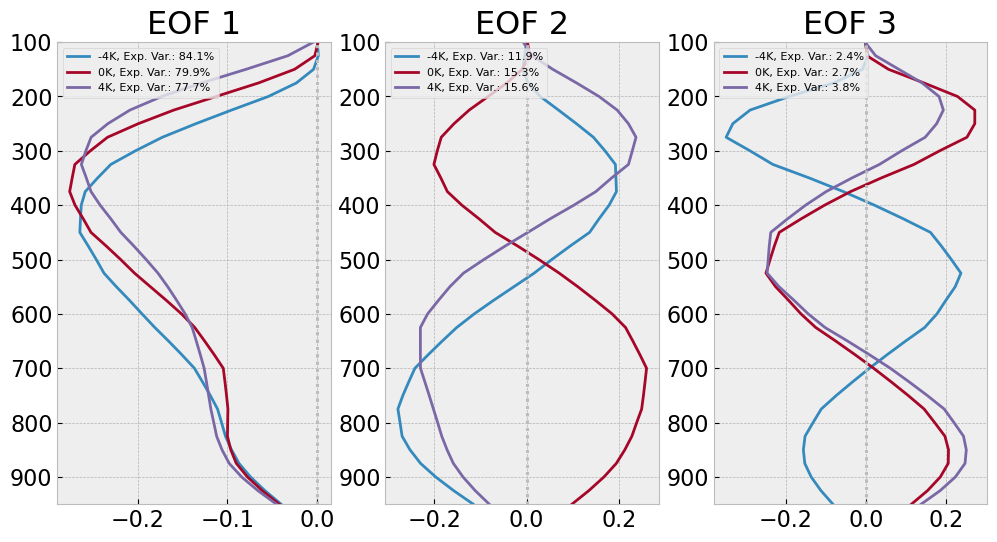

In [77]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':16})
indices_to_plot = 3
[fig, ax] = plt.subplots(1, indices_to_plot, figsize=(4*indices_to_plot,6))
for exp_index, experiment in enumerate(experiments_list):
    for index in range(1, indices_to_plot+1):
        ax[index-1].set_title(f"EOF {index}")
        ax[index-1].plot(
            EOF.sel(experiment=experiment, index=index),
            EOF.plev,
            color=bmh_colors(exp_index+1),
            label=f"{experiment}, Exp. Var.: {100*eigenvalue_spectrum.sel(experiment=experiment, index=index).values:0.1f}%"
        )

        ax[index-1].axvline(x=0, ls=':', color="#bcbcbc")
        ax[index-1].legend(loc='upper left', fontsize=8)
        ax[index-1].set_ylim(100, 950)
        ax[index-1].set_yticks(np.arange(100, 1000, 100))
        ax[index-1].invert_yaxis()

plt.show()

### Eigenvalue Spectra

Variable: Vertical Wind


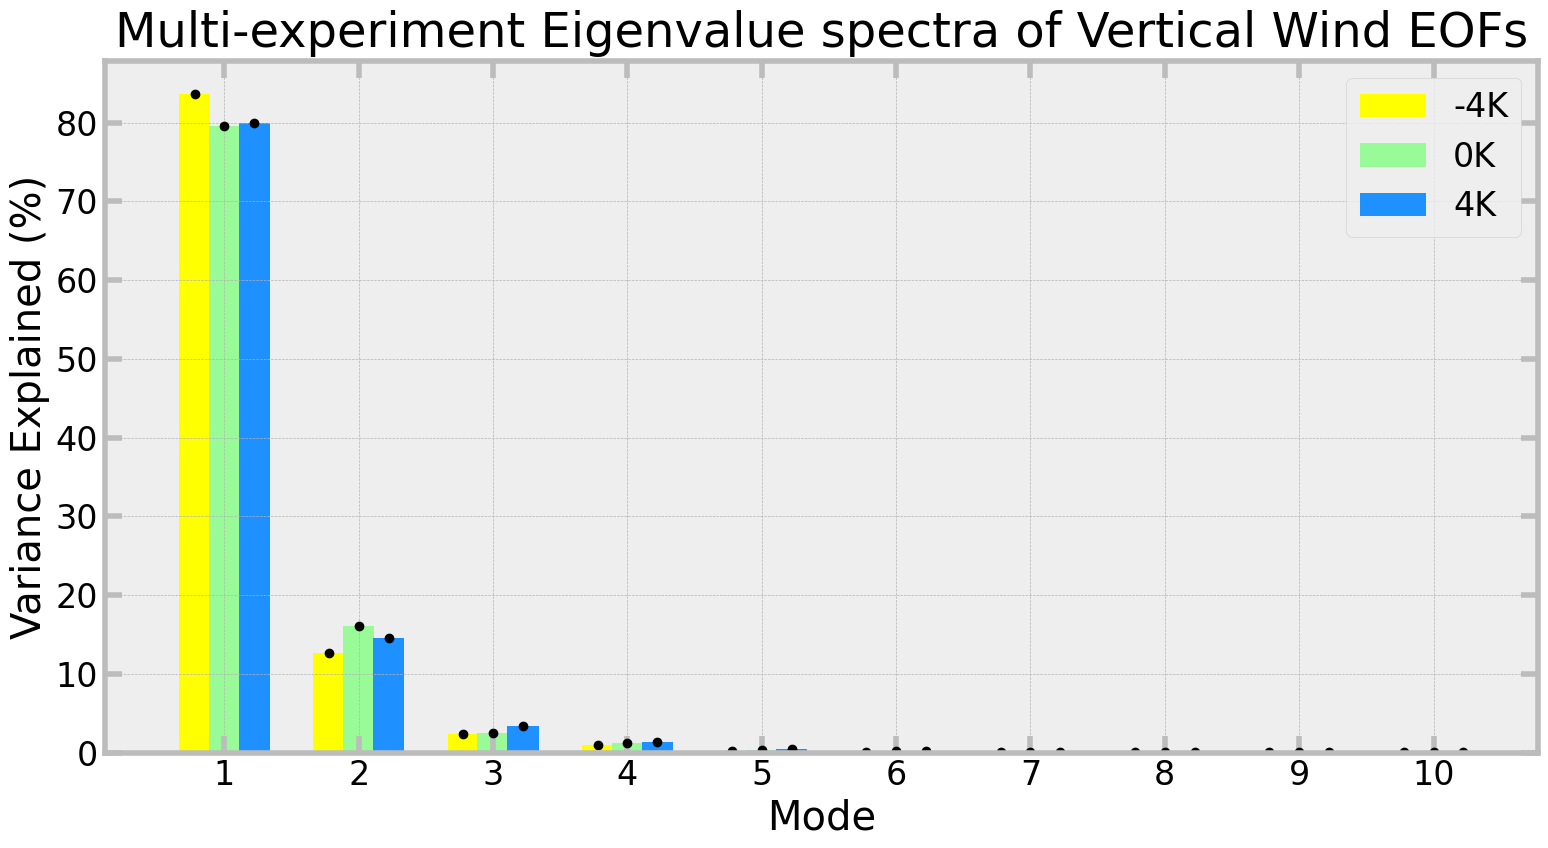

Finished


In [42]:
output_directory = "/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False

print(f"Variable: {compositing_variable.name}")

plt.style.use("bmh")
plt.rcParams.update({"font.size": 24})

[fig, ax] = plt.subplots(figsize=(16, 9))
num_modes = 10
jump = 1.5
EOF_index = np.arange(1, 1 + (num_modes*jump), jump)

ax.set_title(
    f"Multi-experiment Eigenvalue spectra of "
  + f"{compositing_variable.name} EOFs",
    pad=10
)

for experiment_index, experiment in enumerate(experiments_list):
    ax.bar(
        EOF_index+experiment_index/3,
        100 * eigenvalue_spectrum.sel(experiment=experiment)[:num_modes],
        width=0.35,
        color=["yellow", "palegreen", "dodgerblue"][experiment_index],
        label=experiment
    )

    ax.errorbar(
        EOF_index+experiment_index/3,
        100 * eigenvalue_spectrum.sel(experiment=experiment)[:num_modes],
        100 * spectrum_error.sel(experiment=experiment)[:num_modes],
        fmt="o",
        lw=2.5,
        color="black",
    )

ax.set_ylabel("Variance Explained (%)")
ax.set_xlabel("Mode")

# Configure and label axes
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(4)

ax.tick_params(
    axis="both",
    which="major",
    length=12,
    width=4,
    color="#bcbcbc",
    direction="in",
    right=True,
    top=True,
    pad=5,
)
ax.legend(loc='upper right')

# ax.set_ylim(0, 15)
ax.set_ylim(bottom=0)
ax.set_xlim(0, EOF_index[-1]+jump)
ax.set_xticks(EOF_index+1/3, labels=np.arange(1,len(EOF_index)+1))
# ax.set_yticks(np.arange(0, 17, 2))

plt.tight_layout()

if not savefig:
    plt.show()
else:
    save_string = (
        f"{experiment}"
      + f"_{compositing_variable.attrs['file_id']}"
      + f"{((str(compositing_variable.plev.values)) if 'plev' in compositing_variable.coords else '')}_eigenvalue-spectra.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/EOFs/single-variable-latitude-longitude/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

print(f"{'='*40}")
print("Finished")

# Regressed Winds

### PC Power Spectra

In [74]:
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = True

print(f"Variable: {compositing_variable.name}")

SEGMENT_LENGTH = 256
OVERLAP = SEGMENT_LENGTH // 2
frequency = {}
spectrum = {}
periods = np.array([100, 60, 30, 20, 15, 10, 5, 3, 2])
frequency_from_period = 1 / periods

for i in range(1, 4):
    (frequency[i], spectrum[i]) = signal.welch(
        (PC.sel(index=i) - PC.sel(index=i).mean(dim='time')),
        fs=1,
        detrend='linear',
        window="hann",
        nperseg=SEGMENT_LENGTH,
        noverlap=OVERLAP,
        axis=1
    )

# # Plot the power spectra
# plt.style.use("bmh")

# [fig, ax] = plt.subplots(figsize=(16, 9))
# ax.set_title(f"Power Spectra of {compositing_variable.attrs['file_id']} Principal Components 1-4", pad=15)
# for i in spectrum:
#     ax.plot(frequency[i], frequency[i] * spectrum[i], label=("PC" + str(i)), lw=4)

# ax.tick_params(
#     which="major", direction="in", color="#bcbcbc", length=8, width=2, pad=15
# )

# ax.tick_params(
#     which="minor", direction="in", color="#bcbcbc", length=4, width=1, pad=15
# )

# # Add vertical lines to show the intraseasonal band
# for period in [100, 20]:
#     ax.axvline(x=1 / period, ls=":", lw=4, color="black", alpha=0.5)

# # Configure axes
# ax.set_xscale("log")
# ax.set_ylabel(rf"[{compositing_variable.attrs['units']}]$^{2}$")
# ax.set_xlabel("Period (days)")
# ax.legend(loc="best")

# for edge in ["top", "bottom", "left", "right"]:
#     ax.spines[edge].set_linewidth(4)

# ax.tick_params(
#     which="major",
#     axis="both",
#     direction="in",
#     top=True,
#     right=True,
#     width=4,
#     length=15,
#     color="#bcbcbc",
#     pad=10,
# )

# # Set tick parameters
# ax.set_xticks(ticks=frequency_from_period)
# ax.xaxis.set_major_formatter(mticker.FixedFormatter(periods))
# ax.set_xlim(1 / 150, 1 / 5)

# plt.tight_layout()

# if not savefig:
#     plt.show()
# else:
#     save_string = (
#         f"{experiment}"
#       + f"_{compositing_variable.attrs['file_id']}"
#       + f"{((str(compositing_variable.plev.values)) if 'plev' in compositing_variable.coords else '')}_power-spectra.png"
#         )
#     print(f"Saving plot as {save_string}")
#     plt.savefig(
#         f"{output_directory}/EOFs/single-variable-latitude-longitude/{save_string}",
#         dpi=500,
#         bbox_inches="tight",
#     )

# print(f"{'='*40}")
# print("Finished")

Variable: Precipitation


In [85]:
projected_zonal_wind = xr.dot(
    -EOF.sel(index=1).differentiate('plev'),
    multi_experiment_variables_subset['Zonal Wind'],
    dim='plev'
)
projected_meridional_wind = xr.dot(
    -EOF.sel(index=1).differentiate('plev'),
    multi_experiment_variables_subset['Meridional Wind'],
    dim='plev'
)

In [97]:
zonal_wind_tendency_first_half = (
            (1/SECONDS_PER_DAY)
            * projected_zonal_wind.sel(time=first_half_subset_bounds).differentiate('time', datetime_unit='D')
        )
zonal_wind_tendency_second_half = (
    (1/SECONDS_PER_DAY)
    * projected_zonal_wind.sel(time=second_half_subset_bounds).differentiate('time', datetime_unit='D')
)
zonal_wind_tendency = xr.concat(
    (zonal_wind_tendency_first_half, zonal_wind_tendency_second_half),
    dim='time'
)

In [107]:
column_temperature = -(100/9.8)*multi_experiment_variables_subset['Temperature'].sel(plev=slice(100, 950)).integrate('plev')

In [108]:
zonal_column_temperature_gradient = (
            (180/np.pi)*column_temperature.differentiate('lon')
            / (EARTH_RADIUS*np.cos(np.deg2rad(column_temperature.lat)))
        )

In [95]:
meridional_distance = (projected_meridional_wind.lat)*(np.pi/180)*(EARTH_RADIUS)
print(meridional_distance)

<xarray.DataArray 'lat' (lat: 34)> Size: 272B
array([-3480198.81743182, -3269277.6769814 , -3058356.53653099,
       -2847435.39608058, -2636514.25563016, -2425593.11517975,
       -2214671.97472934, -2003750.83427892, -1792829.69382851,
       -1581908.5533781 , -1370987.41292769, -1160066.27247727,
        -949145.13202686,  -738223.99157645,  -527302.85112603,
        -316381.71067562,  -105460.57022521,   105460.57022521,
         316381.71067562,   527302.85112603,   738223.99157644,
         949145.13202686,  1160066.27247727,  1370987.41292768,
        1581908.5533781 ,  1792829.69382851,  2003750.83427892,
        2214671.97472934,  2425593.11517975,  2636514.25563016,
        2847435.39608058,  3058356.53653099,  3269277.6769814 ,
        3480198.81743181])
Coordinates:
    index    int64 8B 1
  * lat      (lat) float64 272B -31.26 -29.37 -27.47 ... 27.47 29.37 31.26


In [99]:
dry_gravity_wave_speed = 50
gross_dry_stability = 3.12*10**4
beta = 2.28*10**(-11)

In [109]:
estimated_c2Ms = (-zonal_wind_tendency + beta*meridional_distance*projected_meridional_wind)/zonal_column_temperature_gradient
print(estimated_c2Ms.mean(dim=['time', 'lat', 'lon']).values)
print(dry_gravity_wave_speed**2/gross_dry_stability)

[-0.00061153 -0.0011859  -0.00080083]
0.08012820512820513


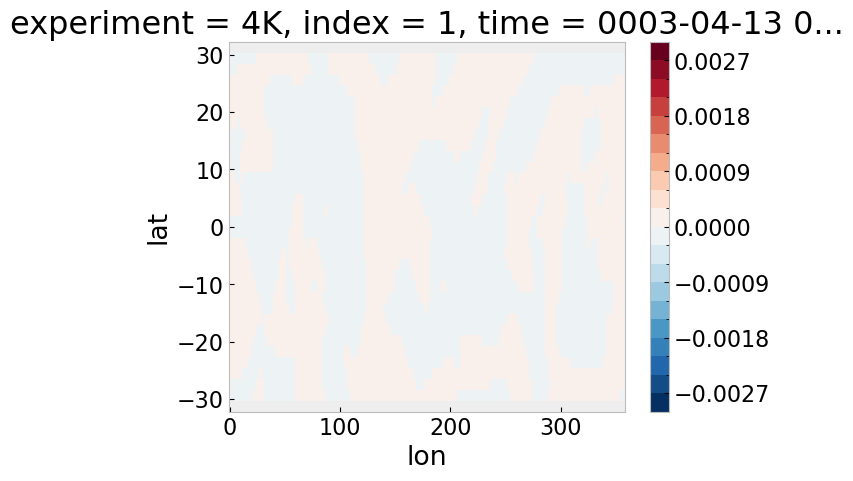

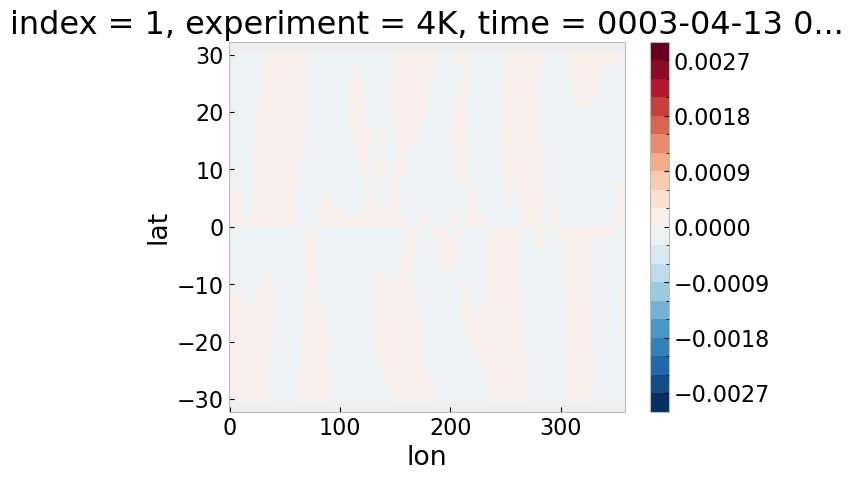

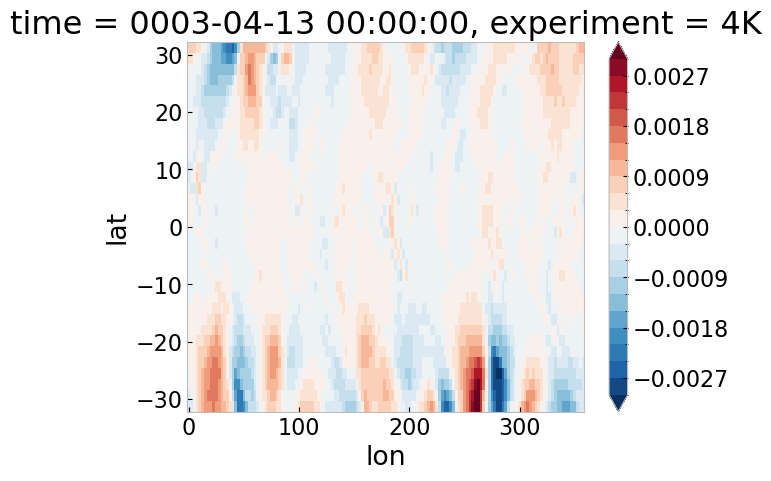

In [119]:
(zonal_wind_tendency.sel(experiment='4K').isel(time=100)).plot(levels=np.linspace(-0.003, 0.003, 21))
plt.figure()
(-beta*meridional_distance*projected_meridional_wind.sel(experiment='4K').isel(time=100)).plot(levels=np.linspace(-0.003, 0.003, 21))
plt.figure()
((dry_gravity_wave_speed**2/gross_dry_stability)*zonal_column_temperature_gradient.sel(experiment='4K').isel(time=100)).plot(levels=np.linspace(-0.003, 0.003, 21))